In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

os.chdir('../src')
from trainer import Trainer


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
BATCH_SIZE = 4096
NUM_CLASSES = 2
NODES_PER_CLASS = 15

def load_data(num_classes):
    df = pd.read_csv('../examples/mnist%d_train.txt' % num_classes, sep=' ', header=None)
    features, labels = df.iloc[:, :-1].values, df.iloc[:, -1:].values
    return features, labels

X, y = load_data(NUM_CLASSES)

In [61]:
class BinaryNN:
    '''
    Class for Binary Neural Network

    Arguments
    ---------
    - num_classes: int, default 2

    - input_shape: int, default None
        must be specified if init_weights is not Numpy array

    - nodes_per_class: int, default 15
        the number of hidden nodes used for each class

    - init_weights: None, or Numpy array
        if Numpy array, should be in shape of (nodes_per_class * num_classes, input_shape)
    '''

    def __init__(self, num_classes=2, input_shape=51, nodes_per_class=15, init_weights=None):
        self.num_classes = num_classes
        self.input_shape = input_shape
        self.nodes_per_class = nodes_per_class
        self.hidden_nodes = nodes_per_class * num_classes
        self.weights = init_weights.reshape((self.hidden_nodes, self.input_shape))

    def predict(self, X, batch_size=64):
        '''
        Arguments
        ---------
        - X: Numpy array
            Should be in shape of (num_samples, input_shape)

        - batch_size: int, default 128
            The number of samples used for each batch of computation to predict
        
        Returns
        -------
        - result: Numpy array
            prediction result in shape of (num_samples, 1)

        '''
        result = []
        
        for i in range(0, len(X), batch_size):
            x = X[i:i+batch_size]     # shape [batch_size, input_shape]
            x = x.dot(self.weights.T)   # shape [batch_size, hidden_nodes]

            class_sum = []
            for j in range(0, self.hidden_nodes, self.nodes_per_class):
                sum_class = x[:, j:j+self.nodes_per_class]
                sum_class = sum_class.sum(axis=1)
                class_sum.append(sum_class)

            class_sum = np.vstack(class_sum).T
            class_sum = class_sum.argmax(axis=1)
            result.append(class_sum)

        result = np.hstack(result).reshape(-1, 1)
        return result

In [70]:
seed = 42
num_generations = 100
pop_size = 150
crossover_rate = 0.95
mutation_rate = 0.15
chromosome_length = 51 * NODES_PER_CLASS * NUM_CLASSES

np.random.seed(seed)

def fitness(chromosome):
    init_weights = 2 * chromosome.genotype - 1
    bnn = BinaryNN(num_classes=NUM_CLASSES, init_weights=init_weights)
    y_pred = bnn.predict(X, batch_size=BATCH_SIZE)
    return accuracy_score(y, y_pred)


trainer = Trainer(
    chromosome_type='binary',
    chromosome_length=chromosome_length,
    fitness_function=fitness,
    pop_size=pop_size,
    selection='tournament',
    crossover_rate=crossover_rate,
    mutation_rate=mutation_rate,
    seed=seed
)

history = trainer.run(num_generations=num_generations)

Iteration   [0] ---- Best fitness: 0.7711 ---- Average fitness: 0.5596
Iteration   [1] ---- Best fitness: 0.7808 ---- Average fitness: 0.6121
Iteration   [2] ---- Best fitness: 0.8101 ---- Average fitness: 0.6529
Iteration   [3] ---- Best fitness: 0.8765 ---- Average fitness: 0.6996
Iteration   [4] ---- Best fitness: 0.8381 ---- Average fitness: 0.7261
Iteration   [5] ---- Best fitness: 0.8635 ---- Average fitness: 0.7534
Iteration   [6] ---- Best fitness: 0.8618 ---- Average fitness: 0.7822
Iteration   [7] ---- Best fitness: 0.9084 ---- Average fitness: 0.8033
Iteration   [8] ---- Best fitness: 0.9051 ---- Average fitness: 0.8194
Iteration   [9] ---- Best fitness: 0.9103 ---- Average fitness: 0.8363
Iteration   [10] ---- Best fitness: 0.9103 ---- Average fitness: 0.8538
Iteration   [11] ---- Best fitness: 0.9209 ---- Average fitness: 0.8643
Iteration   [12] ---- Best fitness: 0.9220 ---- Average fitness: 0.8738
Iteration   [13] ---- Best fitness: 0.9249 ---- Average fitness: 0.8830
It

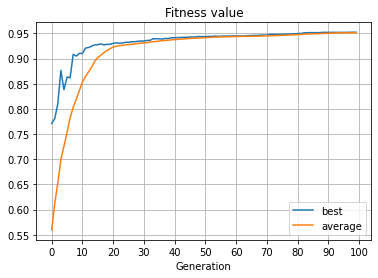

In [71]:
plt.plot(history['best'], label='best')
plt.plot(history['average'], label='average')

step = num_generations // 10
plt.xticks(range(0, num_generations + step, step))

plt.grid()
plt.legend()
plt.xlabel('Generation')
plt.title('Fitness value')
plt.show()

In [72]:
best_solution = trainer.best_chromosome.genotype
best_solution = 2 * best_solution.reshape(51, NODES_PER_CLASS * NUM_CLASSES) - 1
best_solution = best_solution.tolist()

code = f'''A = {best_solution}

for a in A:
    print(' '.join(map(str, a)))
'''

with open('../examples/mnist2_solution.py', 'w') as file:
    print(code, file=file)